#Падалко Богдан. Лаборатная работа №4.

##Генерация получасовых данных за 5 лет

In [1]:
import datetime as dt
from dateutil.relativedelta import relativedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
np.random.seed = 73
tf.random.set_seed(73)

Код для генерации датасета с информацией о погоде скопирован из первой лабораторной работы и модифицирован для генерации данных за 5 лет.

In [2]:
daytemplist = [0, 6, 5, 17, 20, 29, 30, 33, 22, 15, 8, 2]
nighttemplist = [-2, 1, -2, 9, 10, 18, 19, 22, 14, 12, 7, 0]
meantemplist = [-0.9, 3.3, 1.5, 12.8, 15.2, 23.5, 24.2, 26.5, 17.2, 11.5, 5.0, 0.1]
relhumiditylist = [0.85, 0.84, 0.6, 0.72, 0.61, 0.51, 0.53, 0.45, 0.63, 0.72, 0.77, 0.77]

In [3]:
def CalculateAtmosphericPressure(P_0, h, T):
  '''
  Вычисляет атмосферное давление в гектопаскалях.
  P_0 - давление на уровне моря, в гектопаскалях.
  h - высота над уровнем моря, в метрах.
  T - температура, в Цельсиях.
  '''
  return P_0*np.power(1-(0.0065*h/(T+0.0065*h+273.15)), 5.257)

In [4]:
def RelativeWeatherFunction(delta, min_value, max_value):
  '''
  Функция, возвращающая новое значение для параболы min_value -> max_value -> min_value по заданной delta, используя np.sin в промежутке от 0 до np.pi.
  '''
  if delta >= 1.0 or delta <= 0.0:
    return min_value
  if delta == 0.5:
    return max_value
  f = np.sin(delta*np.pi)
  return (f*(max_value-min_value))+min_value

In [5]:
temp_bias = 5
relhumidity_bias = 0.05

In [6]:
fulldata_start = dt.datetime(2022, 1, 1)
fulldata_finish = dt.datetime(2022, 12, 31)+relativedelta(years = 4, hours = 23, minutes = 30)
fulldata_range = pd.date_range(fulldata_start, fulldata_finish, freq = "0.5H")
coords_data = pd.Series(np.random.randn(len(fulldata_range)), index = fulldata_range).to_frame(name = "temperature")
coords_data["temperature"] = pd.NaT
coords_data["atmpressure"] = pd.NaT
coords_data["relhumidity"] = pd.NaT
coords_data["illuminance"] = pd.NaT
coords_data = coords_data.rename_axis("date")

In [7]:
for k in range(5):
  data_start = dt.datetime(2022, 1, 1)+relativedelta(years = k)
  data_finish = dt.datetime(2022, 12, 31)+relativedelta(years = k, hours = 23, minutes = 30)
  data_range = pd.date_range(data_start, data_finish, freq = "0.5H")
  daynightperclist = {}
  daynightperclist.update({data_start.date(): (8*60+34)/60/24})
  daynightperclist.update({(data_start+relativedelta(months = 2, days = 19)).date(): (12*60+10)/60/24})
  daynightperclist.update({(data_start+relativedelta(months = 5, days = 20)).date(): (15*60+55)/60/24})
  daynightperclist.update({(data_start+relativedelta(months = 8, days = 22)).date(): (12*60+7)/60/24})
  daynightperclist.update({(data_start+relativedelta(months = 11, days = 30)).date(): (8*60+32)/60/24})
  current_daylightperc = daynightperclist[data_start.date()]
  for i in range(0, 12):
    d1 = data_start+relativedelta(months = i)
    d2 = data_start+relativedelta(months = i+1, hours = -1)
    for day_timestamp in pd.date_range(d1, d2, freq = "D"):
      day_mintemp = nighttemplist[i]+np.random.uniform(-1*temp_bias, temp_bias)
      day_maxtemp = daytemplist[i]+np.random.uniform(-1*temp_bias, temp_bias)
      day_minrelhumidity = relhumiditylist[i]-np.random.uniform(-1*relhumidity_bias, relhumidity_bias)
      day_maxrelhumidity = relhumiditylist[i]+np.random.uniform(-1*relhumidity_bias, relhumidity_bias)
      timestamp_date = day_timestamp.date()
      if timestamp_date in daynightperclist:
        current_daylightperc = daynightperclist[timestamp_date]
      else:
        dn_date_left = timestamp_date
        dn_date_right = timestamp_date
        for dn_date in daynightperclist:
          if timestamp_date < dn_date:
            if dn_date_right == timestamp_date or dn_date_right > dn_date:
              dn_date_right = dn_date
          elif timestamp_date > dn_date:
            if dn_date_left == timestamp_date or dn_date_left < dn_date:
              dn_date_left = dn_date
        if timestamp_date != dn_date_left and timestamp_date != dn_date_right:
          date_relative = (timestamp_date-dn_date_left).days/(dn_date_right-dn_date_left).days
          daylightperc_left = daynightperclist[dn_date_left]
          daylightperc_right = daynightperclist[dn_date_right]
          if daylightperc_left > daylightperc_right:
            current_daylightperc = RelativeWeatherFunction(0.5*(1.0-date_relative), daylightperc_right, daylightperc_left)
          else:
            current_daylightperc = RelativeWeatherFunction(0.5*date_relative, daylightperc_left, daylightperc_right)
      for j in range(0, 48):
        dayhour_timestamp = day_timestamp+relativedelta(hours = 0.5*j)
        n = RelativeWeatherFunction(j/48, day_mintemp, day_maxtemp)
        coords_data.loc[dayhour_timestamp, "temperature"] = n
        coords_data.loc[dayhour_timestamp, "atmpressure"] = 0.75*CalculateAtmosphericPressure(1310, 72, n)
        coords_data.loc[dayhour_timestamp, "relhumidity"] = 100.0*RelativeWeatherFunction(j/48, day_minrelhumidity, day_maxrelhumidity)
        coords_data.loc[dayhour_timestamp, "illuminance"] = 100000.0*current_daylightperc

In [8]:
coords_data = coords_data.astype(float)
coords_data.to_csv("Padalko_LR4_WeatherData.csv")

In [9]:
display(coords_data.head())
display(coords_data.tail())
display(coords_data.describe())

,temperature,atmpressure,relhumidity,illuminance
date,,,,
2022-01-01 00:00:00,-3.096955,973.597414,81.231753,35694.444444
2022-01-01 00:30:00,-2.583470,973.614218,81.701784,35694.444444
2022-01-01 01:00:00,-2.072184,973.630887,82.169802,35694.444444
2022-01-01 01:30:00,-1.565286,973.647352,82.633803,35694.444444
2022-01-01 02:00:00,-1.064947,973.663544,83.091800,35694.444444


,temperature,atmpressure,relhumidity,illuminance
date,,,,
2026-12-31 21:30:00,0.111961,973.701398,80.345420,35555.555556
2026-12-31 22:00:00,-0.092703,973.694839,80.277226,35555.555556
2026-12-31 22:30:00,-0.300988,973.688153,80.207825,35555.555556
2026-12-31 23:00:00,-0.512004,973.681369,80.137515,35555.555556
2026-12-31 23:30:00,-0.724847,973.674516,80.066595,35555.555556


,temperature,atmpressure,relhumidity,illuminance
count,87648.000000,87648.000000,87648.000000,87648.000000
mean,13.288670,974.093045,66.552670,53032.498821
std,10.464988,0.303975,12.852428,9093.537513
min,-6.992240,973.467837,40.007327,35555.555556
25%,3.888935,973.820721,56.360609,46361.306819
50%,12.999957,974.095659,67.153117,51222.165411
75%,21.677084,974.341784,76.695735,61867.486106
max,37.856098,974.764194,89.953385,66319.444444


##Подготовка к прогнозированию

Функция организации временных интервалов:

In [10]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []
  start_index = start_index+history_size
  if end_index is None:
    end_index = len(dataset)-target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

Первые 50000 строк данных будут использоваться для обучения модели, оставшиеся - для её валидации.

In [11]:
TRAIN_SPLIT = 50000

Целевой признак - температура. Все остальные признаки кроме освещённости ему прямо пропорциональны и у него единственного есть фактор случайности при генерации.

##Прогнозирование на основе одномерного временного ряда

In [12]:
target_label = "temperature"

In [13]:
uni_data = coords_data[target_label]
uni_data.index = coords_data.index
display(uni_data)

date
2022-01-01 00:00:00   -3.096955
2022-01-01 00:30:00   -2.583470
2022-01-01 01:00:00   -2.072184
2022-01-01 01:30:00   -1.565286
2022-01-01 02:00:00   -1.064947
                         ...   
2026-12-31 21:30:00    0.111961
2026-12-31 22:00:00   -0.092703
2026-12-31 22:30:00   -0.300988
2026-12-31 23:00:00   -0.512004
2026-12-31 23:30:00   -0.724847
Freq: 30T, Name: temperature, Length: 87648, dtype: float64

array([<Axes: xlabel='date'>], dtype=object)

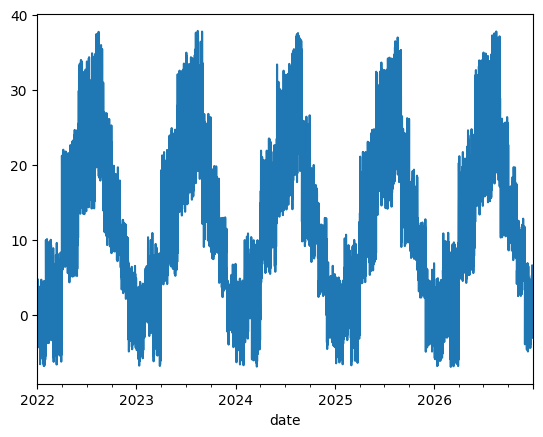

In [14]:
uni_data.plot(subplots = True)

Маштабирование данных с использованием среднего значения и стандартного отклонения.

In [15]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

На вход в модель будут подаваться последние 20 наблюдений за температурой - модель необходимо обучить прогнозировать температуру на следующем шаге.

In [16]:
univariate_past_history = 20
univariate_future_target = 0
x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT, univariate_past_history, univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None, univariate_past_history, univariate_future_target)

In [17]:
def create_time_steps(length):
  return list(range(-length, 0))

In [18]:
def show_plot(plot_data, delta, title):
  labels = ["История", "Истинное будущее", "Предсказание модели"]
  marker = [".-", "rx", "go"]
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0
  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize = 10, label = labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label = labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel("Шаг времени")
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

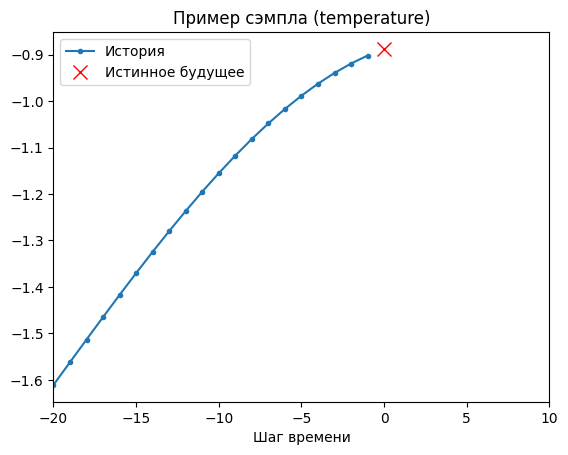

In [19]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, "Пример сэмпла ("+target_label+")")

###Рекуррентная нейронная сеть LSTM (Long Short-Term Memory)

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
simple_lstm_model = tf.keras.models.Sequential([tf.keras.layers.LSTM(8, input_shape = x_train_uni.shape[-2:]), tf.keras.layers.Dense(1)])
simple_lstm_model.compile(optimizer = "adam", loss = "mae")

In [22]:
EVALUATION_INTERVAL = 200
EPOCHS = 10
simple_lstm_model.fit(train_univariate, epochs = EPOCHS, steps_per_epoch = EVALUATION_INTERVAL, validation_data = val_univariate, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 7s 21ms/step - loss: 0.3247 - val_loss: 0.1443
Epoch 2/10
200/200 [==============================] - 3s 13ms/step - loss: 0.1102 - val_loss: 0.0698
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0524 - val_loss: 0.0431
Epoch 4/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0382 - val_loss: 0.0338
Epoch 5/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0312 - val_loss: 0.0287
Epoch 6/10
200/200 [==============================] - 3s 15ms/step - loss: 0.0278 - val_loss: 0.0261
Epoch 7/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0253 - val_loss: 0.0239
Epoch 8/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0234 - val_loss: 0.0220
Epoch 9/10
200/200 [==============================] - 2s 12ms/step - loss: 0.0218 - val_loss: 0.0206
Epoch 10/10
200/200 [==============================] - 3s 17ms/step - loss: 0.0205 - val_lo

8/8 [==============================] - 1s 4ms/step


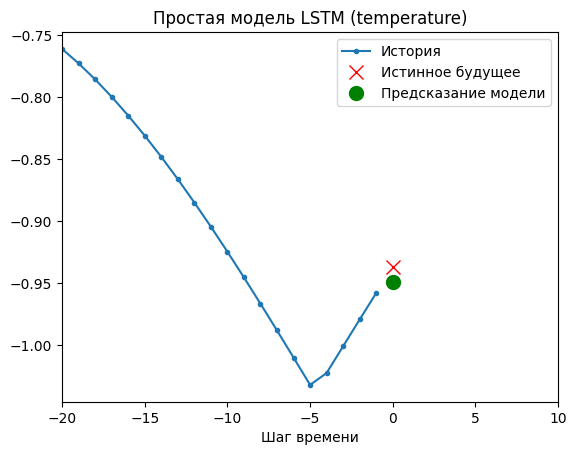

8/8 [==============================] - 0s 4ms/step


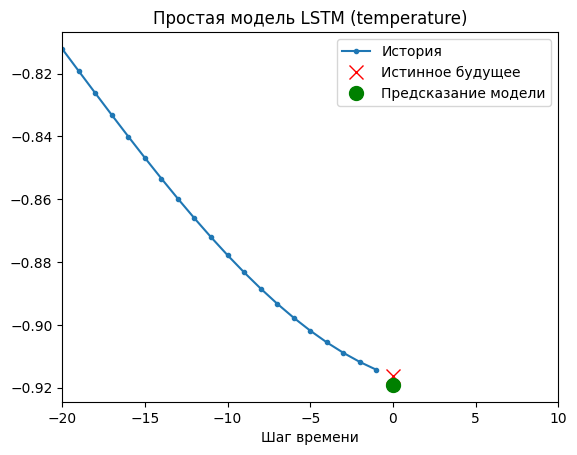

8/8 [==============================] - 0s 3ms/step


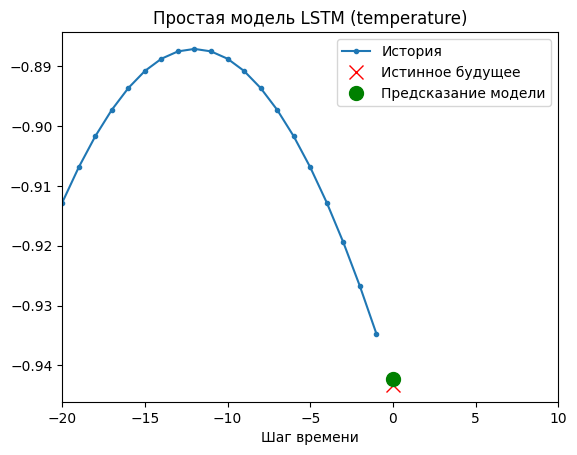

In [23]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(), simple_lstm_model.predict(x)[0]], 0, "Простая модель LSTM ("+target_label+")")
  plot.show()

##Прогнозирование на основе многомерного временного ряда

array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

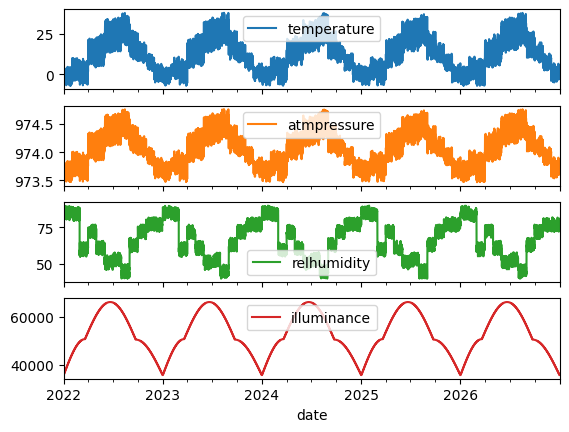

In [24]:
coords_data.plot(subplots = True)

Маштабирование данных с использованием среднего значения и стандартного отклонения.

In [25]:
dataset = coords_data.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis = 0)
data_std = dataset[:TRAIN_SPLIT].std(axis = 0)
dataset = (dataset-data_mean)/data_std

Функция организации временных интервалов:

In [26]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step = False):
  data = []
  labels = []
  start_index = start_index+history_size
  if end_index is None:
    end_index = len(dataset)-target_size
  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])
    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])
  return np.array(data), np.array(labels)

5 дней = 5 x 24 x 2 = 240 получасовых интервала.
Если проводить отбор каждый час, то будет 120 интервалов.

Цель точечного предсказания - значение температуры через 12 часов в будущем - после 12 x 2 = 24 наблюдений.

In [27]:
past_history = 120
future_target = 24
STEP = 2
x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP, single_step = True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP, single_step = True)

In [28]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [29]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape = x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(), loss = "mae")

In [30]:
single_step_history = single_step_model.fit(train_data_single, epochs = EPOCHS, steps_per_epoch = EVALUATION_INTERVAL, validation_data = val_data_single, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 15s 63ms/step - loss: 0.2704 - val_loss: 0.2552
Epoch 2/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2309 - val_loss: 0.2395
Epoch 3/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2189 - val_loss: 0.2239
Epoch 4/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2117 - val_loss: 0.2207
Epoch 5/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2059 - val_loss: 0.2261
Epoch 6/10
200/200 [==============================] - 11s 57ms/step - loss: 0.2026 - val_loss: 0.2104
Epoch 7/10
200/200 [==============================] - 11s 53ms/step - loss: 0.1997 - val_loss: 0.2182
Epoch 8/10
200/200 [==============================] - 11s 55ms/step - loss: 0.1974 - val_loss: 0.2154
Epoch 9/10
200/200 [==============================] - 12s 58ms/step - loss: 0.1935 - val_loss: 0.2093
Epoch 10/10
200/200 [==============================] - 12s 58ms/step - loss: 0.192

In [31]:
def plot_train_history(history, title):
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  epochs = range(len(loss))
  plt.figure()
  plt.plot(epochs, loss, "b", label = "Потери при тренировке")
  plt.plot(epochs, val_loss, "r", label = "Потери при валидации")
  plt.title(title)
  plt.legend()
  plt.show()

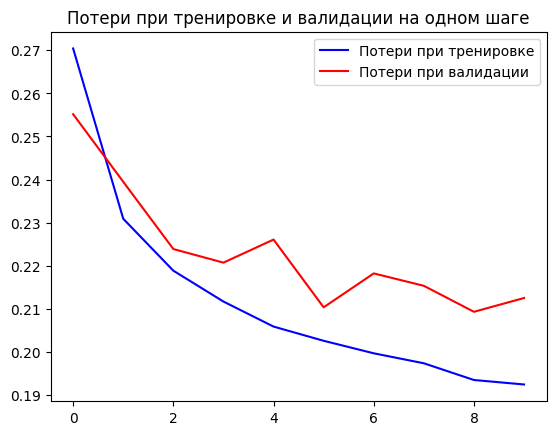

In [32]:
plot_train_history(single_step_history, "Потери при тренировке и валидации на одном шаге")

###Выполнение точечного прогноза

Выполним несколько прогнозов.

8/8 [==============================] - 1s 8ms/step


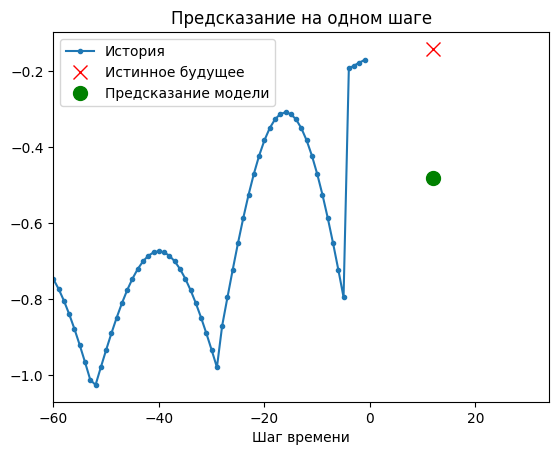

8/8 [==============================] - 0s 9ms/step


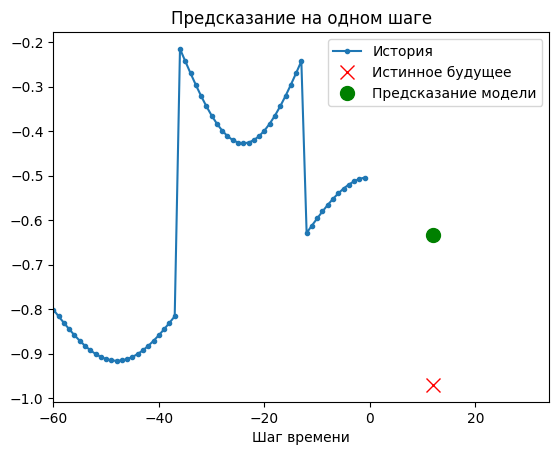

8/8 [==============================] - 0s 8ms/step


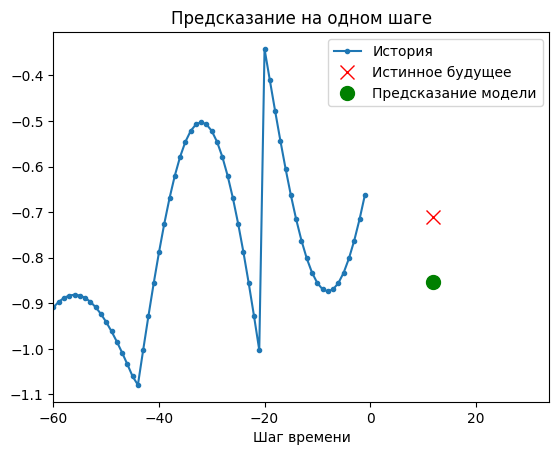

In [33]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(), single_step_model.predict(x)[0]], 12, "Предсказание на одном шаге")
  plot.show()

##Интервальное прогнозирование

In [34]:
future_target = 24
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history, future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history, future_target, STEP)

In [35]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [36]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize = (12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)
  plt.plot(num_in, np.array(history[:, 1]), label = "История")
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), "bo", label = "Истинное будущее")
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro', label = "Предсказанное будущее")
  plt.legend(loc = "upper left")
  plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные.

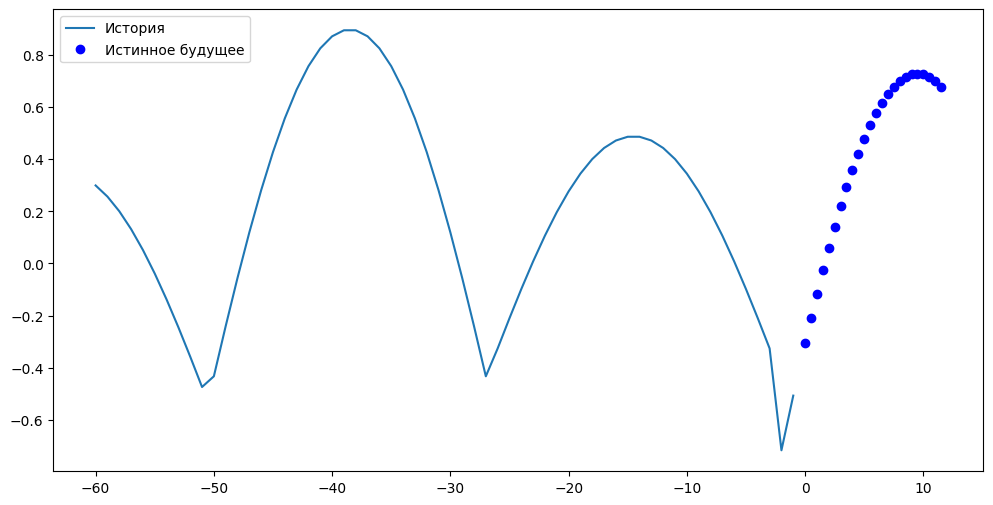

In [37]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. 24 прогноза = 24 нейрона выходного слоя.

In [38]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32, return_sequences = True, input_shape = x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation = "relu"))
multi_step_model.add(tf.keras.layers.Dense(24))
multi_step_model.compile(optimizer = tf.keras.optimizers.RMSprop(clipvalue = 1.0), loss = "mae")

In [39]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs = EPOCHS, steps_per_epoch = EVALUATION_INTERVAL, validation_data = val_data_multi, validation_steps = 50)

Epoch 1/10
200/200 [==============================] - 25s 108ms/step - loss: 0.4453 - val_loss: 0.2862
Epoch 2/10
200/200 [==============================] - 20s 102ms/step - loss: 0.2720 - val_loss: 0.2507
Epoch 3/10
200/200 [==============================] - 21s 107ms/step - loss: 0.2400 - val_loss: 0.2187
Epoch 4/10
200/200 [==============================] - 21s 106ms/step - loss: 0.2091 - val_loss: 0.1995
Epoch 5/10
200/200 [==============================] - 21s 104ms/step - loss: 0.1918 - val_loss: 0.1852
Epoch 6/10
200/200 [==============================] - 21s 106ms/step - loss: 0.1791 - val_loss: 0.1788
Epoch 7/10
200/200 [==============================] - 20s 102ms/step - loss: 0.1701 - val_loss: 0.1708
Epoch 8/10
200/200 [==============================] - 21s 107ms/step - loss: 0.1639 - val_loss: 0.1674
Epoch 9/10
200/200 [==============================] - 22s 112ms/step - loss: 0.1588 - val_loss: 0.1613
Epoch 10/10
200/200 [==============================] - 32s 162ms/step - l

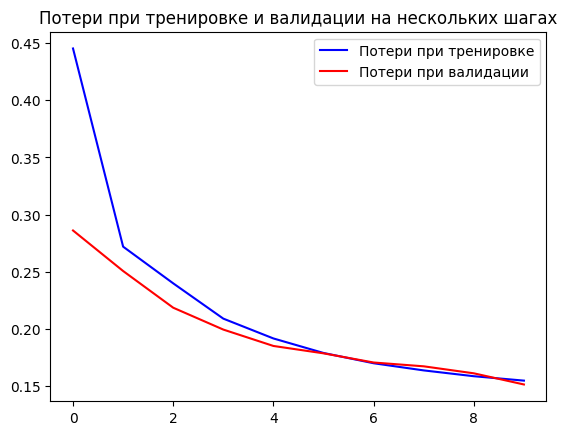

In [40]:
plot_train_history(multi_step_history, "Потери при тренировке и валидации на нескольких шагах")

###Выполнение интервального прогноза

8/8 [==============================] - 1s 13ms/step


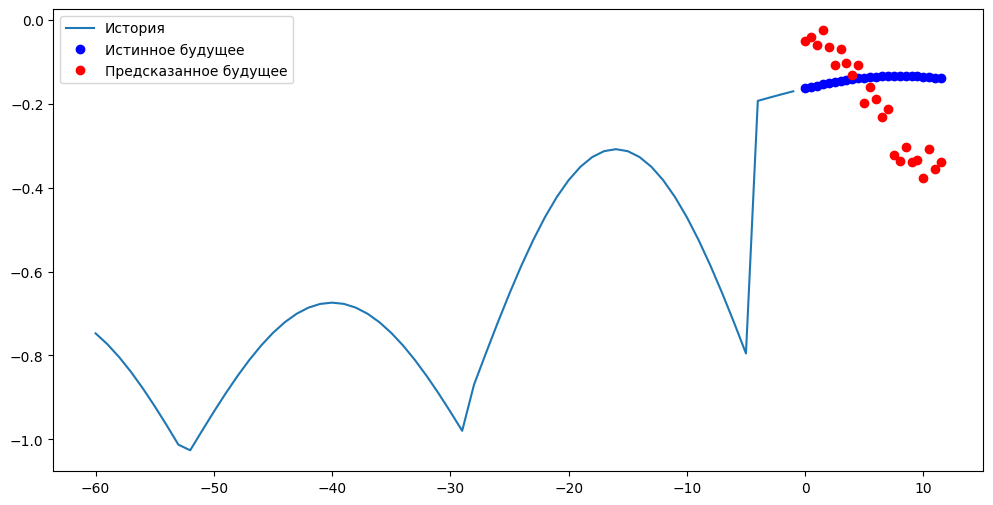

8/8 [==============================] - 0s 14ms/step


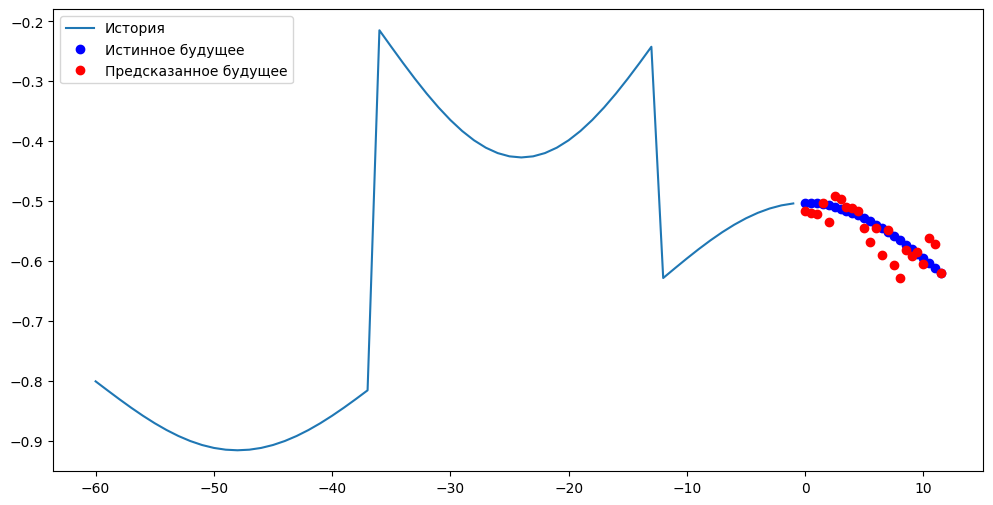

8/8 [==============================] - 0s 15ms/step


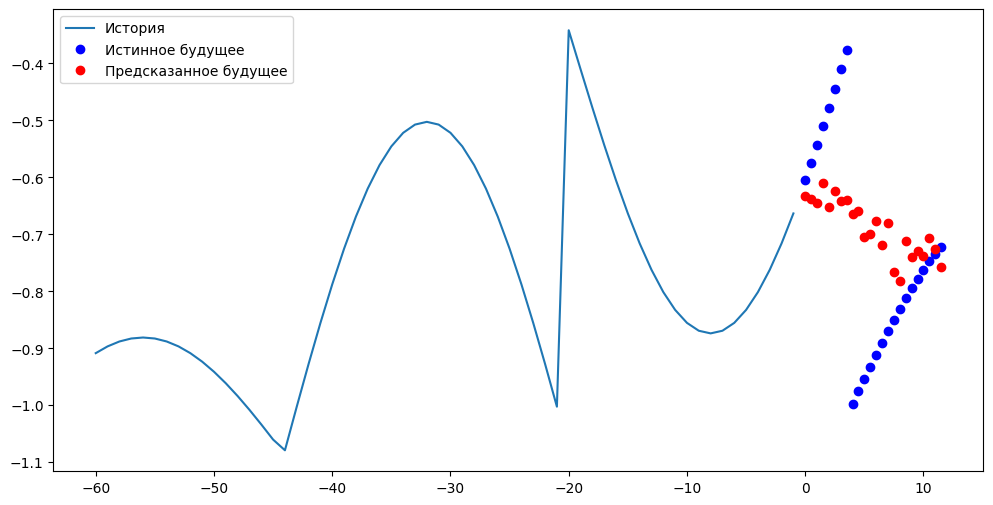

In [41]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])